In [ ]:
%pip install lightgbm
%pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 111 kB/s 


### Load du fichier

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os

"""
Quand on voudra appliquer à train + test 
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv('test.csv')
df =  pd.concat([df_train, df_test])
"""

df = pd.read_csv("train.csv")

display(df)


,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
0,ConcertExperience_180106,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,concert_goer_1985,140.0,Paraguay,Did Not Enjoy
1,ConcertExperience_146268,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,concert_goer_1874,158.0,United Kingdom (UK),Enjoyed
2,ConcertExperience_128743,Ron Talent,Rock n Roll,Canada,1955.0,NaN,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,concert_goer_442,159.0,United States of America (USA),Did Not Enjoy
3,ConcertExperience_140839,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,concert_goer_1149,150.0,Canada,Worst Concert Ever
4,ConcertExperience_19149,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,concert_goer_930,166.0,United Kingdom (UK),Did Not Enjoy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,ConcertExperience_14055,Crazy Joystick Cult,RnB,Canada,1985.0,70.0,162754.0,True,False,False,-0.095021,0.175175,0.914245,0.357359,50.0,concert_goer_707,180.0,United States of America (USA),Did Not Enjoy
169996,ConcertExperience_192792,Crazy Joystick Cult,RnB,Canada,1985.0,963.0,54.0,False,False,False,-0.733719,-0.285776,-0.323312,0.641180,71.0,concert_goer_1373,143.0,Bulgaria,Worst Concert Ever
169997,ConcertExperience_152942,"Why Frogs, Why?",Heavy Metal,Canada,2005.0,764.0,54.0,False,False,False,0.744969,-0.965547,1.020598,1.027389,27.0,concert_goer_1286,176.0,Canada,Did Not Enjoy
169998,ConcertExperience_138957,Twilight of the Joystick Gods,Hip Hop/Rap,United States of America (USA),1995.0,694.0,22026.0,False,True,True,0.821976,0.351411,0.175762,1.455654,39.0,concert_goer_1845,176.0,Canada,Did Not Enjoy


## Distribution des labels

In [ ]:
df['Concert Enjoyment'].value_counts()

Enjoyed               68026
Did Not Enjoy         67945
Best Concert Ever     17027
Worst Concert Ever    17002
Name: Concert Enjoyment, dtype: int64

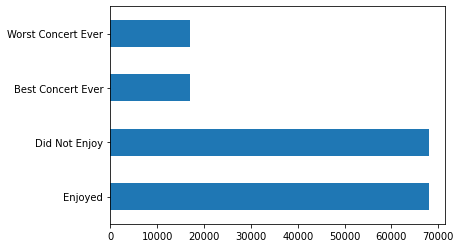

In [ ]:
ax = df['Concert Enjoyment'].value_counts().plot(kind='barh')
ax.set_xscale('linear')

On observe une certaine asymétrie(skewness) des labels.

## Informations sur le dataset

In [ ]:
df.columns

Index(['Id', 'Band Name', 'Band Genre', 'Band Country of Origin', 'Band Debut',
       'Concert ID', 'Concert Attendance', 'Inside Venue', 'Rain', 'Seated',
       'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3',
       'Personnality Trait 4', 'Concert Goer Age', 'Concert Goer ID',
       'Height (cm)', 'Concert Goer Country of Origin', 'Concert Enjoyment'],
      dtype='object')

In [ ]:
shape = df.shape
print("Nb lignes = ", shape[0], "\nNb cols = " , shape[1],"\n")
df.info()

Nb lignes =  170000 
Nb cols =  19 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170000 entries, 0 to 169999
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Id                              170000 non-null  object 
 1   Band Name                       169141 non-null  object 
 2   Band Genre                      169116 non-null  object 
 3   Band Country of Origin          169210 non-null  object 
 4   Band Debut                      169143 non-null  float64
 5   Concert ID                      169130 non-null  float64
 6   Concert Attendance              169105 non-null  float64
 7   Inside Venue                    169162 non-null  object 
 8   Rain                            169139 non-null  object 
 9   Seated                          169168 non-null  object 
 10  Personnality Trait 1            169148 non-null  float64
 11  Personnality Trait 2            169151 no

In [ ]:
cat_cols = [col for col in df.columns if col not in df.describe().columns]
num_cols = [col for col in df.columns if col in df.describe().columns]
print("Le nb de colonnes catégorielles est de", len(cat_cols), ". Ce sont :",cat_cols)
print("Le nb de colonnes numériques est de", len(num_cols), ". Ce sont :",num_cols)


Le nb de colonnes catégorielles est de 10 . Ce sont : ['Id', 'Band Name', 'Band Genre', 'Band Country of Origin', 'Inside Venue', 'Rain', 'Seated', 'Concert Goer ID', 'Concert Goer Country of Origin', 'Concert Enjoyment']
Le nb de colonnes numériques est de 9 . Ce sont : ['Band Debut', 'Concert ID', 'Concert Attendance', 'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4', 'Concert Goer Age', 'Height (cm)']


On remarque que certaines colonnes n'ont pas la bonne catégorie. Ce qui témoigne d'un souci au niveau du typage.

In [ ]:
df.describe()  # s'applique uniquement sur les colonnes numériques    

,Band Debut,Concert ID,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Height (cm)
count,169143.000000,169130.000000,1.691050e+05,169148.000000,169151.000000,169107.000000,169135.000000,169147.000000,169153.000000
mean,1985.895053,499.360587,2.727906e+05,0.030190,-7.776188,-0.017279,0.003432,46.979822,164.660680
std,16.365288,288.640600,1.641506e+07,0.992067,3237.713866,1.004774,1.006310,17.470503,14.365046
min,1955.000000,0.000000,5.400000e+01,-3.124408,-293861.500146,-3.275108,-3.287787,16.000000,140.000000
25%,1976.000000,249.000000,4.030000e+02,-0.638873,-0.689943,-0.711015,-0.698374,32.000000,152.000000
50%,1988.000000,500.000000,2.980000e+03,0.022664,-0.021836,0.010071,0.015264,47.000000,164.000000
75%,1998.000000,749.750000,2.202600e+04,0.698236,0.648032,0.680300,0.700369,63.000000,177.000000
max,2014.000000,999.000000,1.627540e+09,3.628828,325834.016795,3.308810,3.830923,76.000000,190.000000


In [ ]:
df.isnull().sum() # nb de nulls par colonne

Id                                  0
Band Name                         859
Band Genre                        884
Band Country of Origin            790
Band Debut                        857
Concert ID                        870
Concert Attendance                895
Inside Venue                      838
Rain                              861
Seated                            832
Personnality Trait 1              852
Personnality Trait 2              849
Personnality Trait 3              893
Personnality Trait 4              865
Concert Goer Age                  853
Concert Goer ID                   815
Height (cm)                       847
Concert Goer Country of Origin    859
Concert Enjoyment                   0
dtype: int64

##Analyse des données 

On veut voir si il y'a des doublons dans les ID.
Pour cela, on va observer le nb de valeurs dsitinctes par colonnes et le value_counts()

In [ ]:
print("Les valeurs de colonne 'ID' sont différentes pour" ,len(df["Id"].value_counts())/df.shape[0] * 100, "% des valeurs.")

Les valeurs de colonne 'ID' sont différentes pour 100.0 % des valeurs.


Ici l'idée est de voir la distribution des colonnes numériques

In [ ]:
df.columns   

Index(['Id', 'Band Name', 'Band Genre', 'Band Country of Origin', 'Band Debut',
       'Concert ID', 'Concert Attendance', 'Inside Venue', 'Rain', 'Seated',
       'Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3',
       'Personnality Trait 4', 'Concert Goer Age', 'Concert Goer ID',
       'Height (cm)', 'Concert Goer Country of Origin', 'Concert Enjoyment'],
      dtype='object')

Plot pour la colonne  Concert Attendance


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


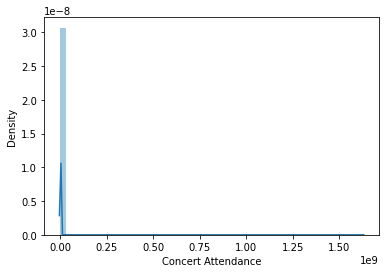



Plot pour la colonne  Personnality Trait 1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


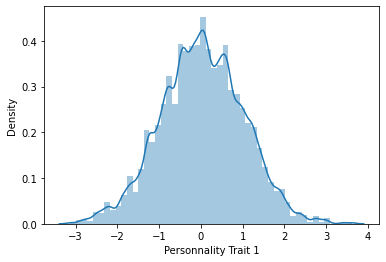



Plot pour la colonne  Personnality Trait 2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


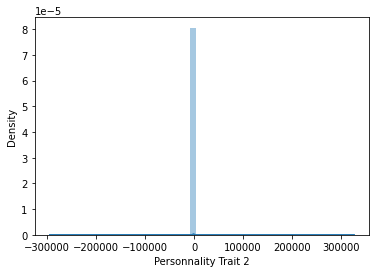



Plot pour la colonne  Personnality Trait 3


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


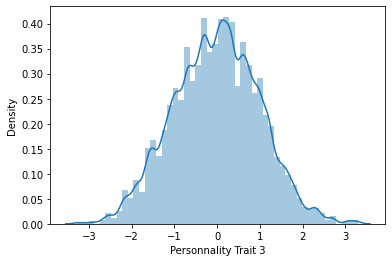



Plot pour la colonne  Personnality Trait 4


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


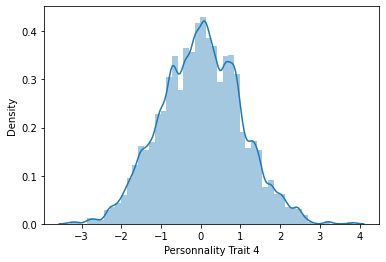



Plot pour la colonne  Concert Goer Age


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


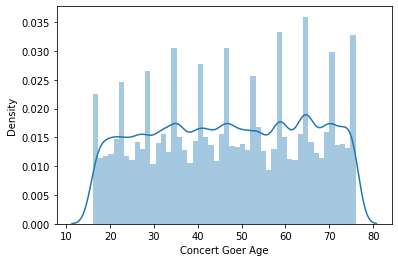



Plot pour la colonne  Height (cm)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


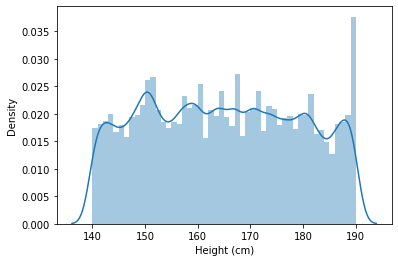

In [ ]:
colonnes_numeriques = ['Concert Attendance','Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3','Personnality Trait 4', 'Concert Goer Age','Height (cm)']

for col in colonnes_numeriques:   
    print("Plot pour la colonne ",col)
    sns.distplot(df[col])
    plt.show()
    print("\n")

Répartition des colonnes catégorielles

Plot pour la colonne  Band Name


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


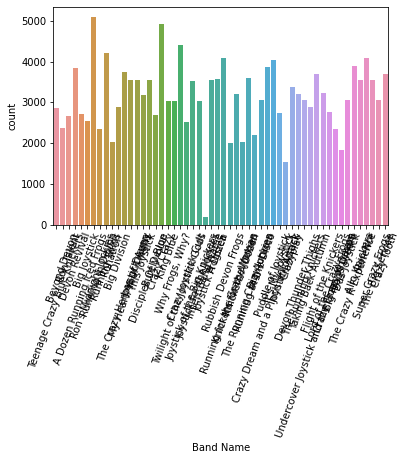



Plot pour la colonne  Band Genre


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


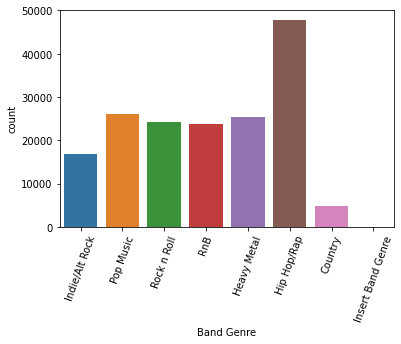



Plot pour la colonne  Band Country of Origin


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


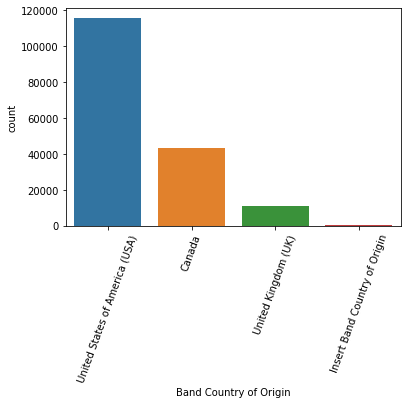



Plot pour la colonne  Band Debut


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


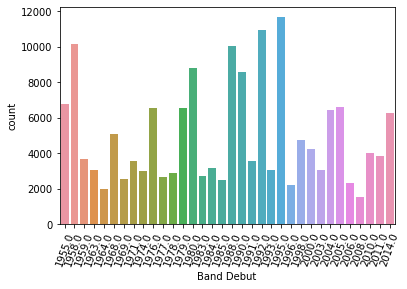



Plot pour la colonne  Concert ID


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


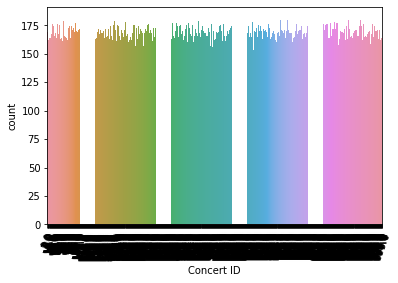



Plot pour la colonne  Inside Venue


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


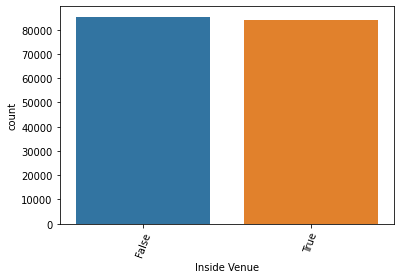



Plot pour la colonne  Rain


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


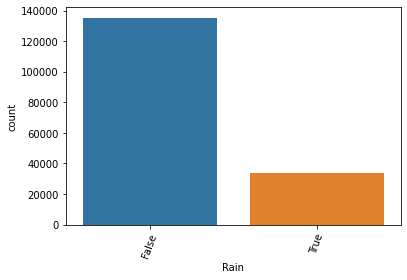



Plot pour la colonne  Seated


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


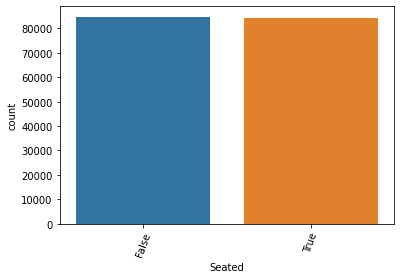



Plot pour la colonne  Concert Goer ID


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


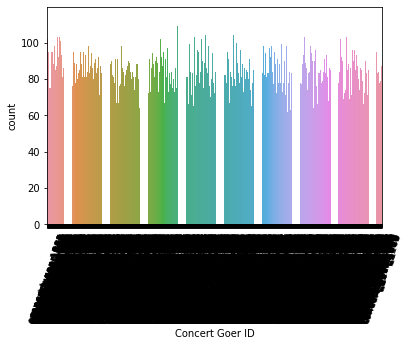



Plot pour la colonne  Concert Goer Country of Origin


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


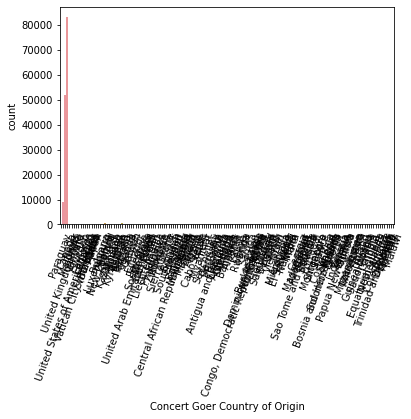

In [ ]:
colonnes_categorielles = ['Band Name', 'Band Genre', 'Band Country of Origin', 'Band Debut',
       'Concert ID', 'Inside Venue', 'Rain', 'Seated', 'Concert Goer ID', 'Concert Goer Country of Origin']
for col in colonnes_categorielles:   
    print("Plot pour la colonne ",col)
    chart = sns.countplot(df[col])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=70)
    plt.show()
    print("\n")



Répartition/Nbr de valeurs distinctes par colonnes (value_counts)

In [ ]:
for col in df.columns[1:18]:    # on ne fait pas la première qui est l'ID ni la dernière qui est la classe car on l'a déjà fait 
    a = df[col].value_counts()
    nbValeursDif = len(a)
    print("Pour la colonne",col,", on a ",nbValeursDif," valeurs différentes")
    print("Pour la colonne",col,":\n\n",a, "\n")

Pour la colonne Band Name , on a  54  valeurs différentes
Pour la colonne Band Name :

 Ron's Midnight Jockies                        5080
Crazy Crazy                                   4929
Twilight of the Joystick Gods                 4402
Running Twins                                 4219
Rubbish Devon Frogs                           4083
Ron Nor                                       4083
Puddle of Joystick                            4046
The Crazy R Experience                        3891
Crazy Dream and a Pinch of Joystick           3874
Devon Revival                                 3835
The Crazy Heroes of Devon                     3738
Crazy Tooth                                   3694
Undercover Joystick and the Crazy Knickers    3689
The Running Crazy Jockies                     3591
Frogsica                                      3560
Joystick Army                                 3558
Super Crazy Frogs                             3557
My Heart, Your Thighs                        

### Matrice de corrélation (uniquement données numérique)

In [ ]:
df.corr()

,Band Debut,Concert ID,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Height (cm)
Band Debut,1.000000,-0.018090,0.001589,0.001778,0.000460,0.001595,0.000317,-0.001369,-0.000381
Concert ID,-0.018090,1.000000,0.004972,0.002316,0.002034,-0.000253,0.002211,0.003196,0.001308
Concert Attendance,0.001589,0.004972,1.000000,0.002275,0.000026,-0.001153,-0.004191,-0.003321,0.000784
Personnality Trait 1,0.001778,0.002316,0.002275,1.000000,0.005117,-0.017076,-0.012334,-0.041758,-0.023573
Personnality Trait 2,0.000460,0.002034,0.000026,0.005117,1.000000,-0.001677,0.002682,-0.001464,0.003277
Personnality Trait 3,0.001595,-0.000253,-0.001153,-0.017076,-0.001677,1.000000,0.027111,-0.020949,0.033102
Personnality Trait 4,0.000317,0.002211,-0.004191,-0.012334,0.002682,0.027111,1.000000,0.012801,0.040108
Concert Goer Age,-0.001369,0.003196,-0.003321,-0.041758,-0.001464,-0.020949,0.012801,1.000000,-0.017692
Height (cm),-0.000381,0.001308,0.000784,-0.023573,0.003277,0.033102,0.040108,-0.017692,1.000000


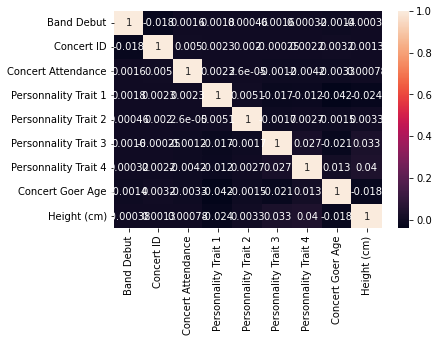

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

### Completeness des lignes

In [ ]:
lendf = df.shape[0]
lenDfNoNa = df.dropna().shape[0]
print("Nb de rows initial = ",lendf)
print("Nb de rows sans null/Nan = ",lenDfNoNa)
print("Si on supprime les lignes avec des null/Nan, on aura une perte d'information de l'ordre de",100 - lenDfNoNa/lendf *100 ,"%")

Nb de rows initial =  170000
Nb de rows sans null/Nan =  156023
Si on supprime les lignes avec des null/Nan, on aura une perte d'information de l'ordre de 8.22176470588235 %


Ici on va mesurer à quelque point on peut être flexible avec le nombre de Nan/ null par lignes.

In [ ]:
lendf = df.shape[0]

for i in range(14,20): 
  lenDfNoNa = df.dropna(thresh=i).shape[0]
  print("Si pour chaque observation , on s'autorise à n'avoir que maximum ", 19-i,"features/colonnes contenant une valeur null/nan, on aura une perte d'information de l'ordre de",100 - lenDfNoNa/lendf *100 ,"%")
  print(lendf , " ---> ", lenDfNoNa,"\n")

Si pour chaque observation , on s'autorise à n'avoir que maximum  5 features/colonnes contenant une valeur null/nan, on aura une perte d'information de l'ordre de 0.0 %
170000  --->  170000 

Si pour chaque observation , on s'autorise à n'avoir que maximum  4 features/colonnes contenant une valeur null/nan, on aura une perte d'information de l'ordre de 0.0 %
170000  --->  170000 

Si pour chaque observation , on s'autorise à n'avoir que maximum  3 features/colonnes contenant une valeur null/nan, on aura une perte d'information de l'ordre de 0.0 %
170000  --->  170000 

Si pour chaque observation , on s'autorise à n'avoir que maximum  2 features/colonnes contenant une valeur null/nan, on aura une perte d'information de l'ordre de 0.007058823529419556 %
170000  --->  169988 

Si pour chaque observation , on s'autorise à n'avoir que maximum  1 features/colonnes contenant une valeur null/nan, on aura une perte d'information de l'ordre de 0.3117647058823536 %
170000  --->  169470 

Si pour 

## Plus encore d'analyse

On peut split le dataframe en fonction de l'appartenance des observations à une classe. Ca permet d'avoir une première idée des tendances de chacune. On réapplique alors toutes les méthodes d'analyses précédentes.

In [ ]:
df1 = df[df['Concert Enjoyment'] =="Enjoyed"]
df2 = df[df['Concert Enjoyment'] =="Did Not Enjoy"]
df3 = df[df['Concert Enjoyment'] =="Best Concert Ever"]
df4 = df[df['Concert Enjoyment'] =="Worst Concert Ever"]

In [ ]:
df1.describe(include='all')

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
count,68026,67681,67677,67727,67698.000000,67686.000000,6.766900e+04,67700,67667,67683,67693.000000,67695.000000,67672.000000,67701.000000,67680.000000,67704,67674.000000,67695,68026
unique,68026,54,8,4,NaN,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,2000,NaN,152,1
top,ConcertExperience_146268,Twilight of the Joystick Gods,Hip Hop/Rap,United States of America (USA),NaN,NaN,NaN,True,False,True,NaN,NaN,NaN,NaN,NaN,concert_goer_255,NaN,Canada,Enjoyed
freq,1,2574,21739,46107,NaN,NaN,NaN,35496,57522,35275,NaN,NaN,NaN,NaN,NaN,59,NaN,33667,68026
mean,NaN,NaN,NaN,NaN,1985.256256,497.050749,2.841103e+05,NaN,NaN,NaN,0.039777,-11.539198,-0.018620,0.004889,45.730304,NaN,164.701894,NaN,NaN
std,NaN,NaN,NaN,NaN,16.393235,289.167306,1.695521e+07,NaN,NaN,NaN,0.990059,3481.917972,1.004578,1.005623,17.340822,NaN,14.384999,NaN,NaN
min,NaN,NaN,NaN,NaN,1955.000000,0.000000,5.400000e+01,NaN,NaN,NaN,-3.124408,-293861.500146,-3.275108,-3.287787,16.000000,NaN,140.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,1974.000000,238.000000,4.030000e+02,NaN,NaN,NaN,-0.622898,-0.683030,-0.711195,-0.695902,31.000000,NaN,152.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,1988.000000,496.000000,2.980000e+03,NaN,NaN,NaN,0.038949,-0.019274,0.007932,0.016231,45.000000,NaN,164.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,1998.000000,752.000000,2.202600e+04,NaN,NaN,NaN,0.704550,0.648299,0.680300,0.700369,60.000000,NaN,177.000000,NaN,NaN


In [ ]:
df2.describe(include='all')

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
count,67945,67587,67588,67626,67601.000000,67585.000000,6.758600e+04,67603,67606,67620,67599.000000,67596.000000,67588.000000,67603.000000,67618.000000,67610,67629.000000,67585,67945
unique,67945,54,8,4,NaN,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,2000,NaN,152,1
top,ConcertExperience_180106,Crazy Crazy,Hip Hop/Rap,United States of America (USA),NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,concert_goer_469,NaN,Canada,Did Not Enjoy
freq,1,2940,17173,45196,NaN,NaN,NaN,35057,52993,34403,NaN,NaN,NaN,NaN,NaN,61,NaN,34067,67945
mean,NaN,NaN,NaN,NaN,1986.901096,501.963587,2.567746e+05,NaN,NaN,NaN,0.023106,4.665830,-0.011050,0.002943,48.109778,NaN,164.591211,NaN,NaN
std,NaN,NaN,NaN,NaN,16.183305,287.760277,1.563022e+07,NaN,NaN,NaN,0.993771,3387.773273,1.001202,1.009395,17.365371,NaN,14.354479,NaN,NaN
min,NaN,NaN,NaN,NaN,1955.000000,0.000000,5.400000e+01,NaN,NaN,NaN,-3.124408,-272185.886248,-3.275108,-3.287787,16.000000,NaN,140.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,1977.000000,261.000000,4.030000e+02,NaN,NaN,NaN,-0.651623,-0.693003,-0.706833,-0.700160,34.000000,NaN,152.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,1990.000000,501.000000,2.980000e+03,NaN,NaN,NaN,0.011515,-0.025158,0.020540,0.014184,49.000000,NaN,164.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,1998.000000,754.000000,2.202600e+04,NaN,NaN,NaN,0.694111,0.646901,0.681197,0.705062,63.000000,NaN,177.000000,NaN,NaN


In [ ]:
df3.describe(include='all')

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
count,17027,16940,16919,16940,16937.000000,16932.000000,1.693800e+04,16945,16937,16941,16940.000000,16951.000000,16948.000000,16932.000000,16945.000000,16948,16931.000000,16938,17027
unique,17027,52,8,4,NaN,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,1972,NaN,152,1
top,ConcertExperience_125567,The Crazy Heroes of Devon,Hip Hop/Rap,United States of America (USA),NaN,NaN,NaN,True,False,True,NaN,NaN,NaN,NaN,NaN,concert_goer_1361,NaN,United States of America (USA),Best Concert Ever
freq,1,1590,5824,12795,NaN,NaN,NaN,9244,14858,8646,NaN,NaN,NaN,NaN,NaN,34,NaN,7302,17027
mean,NaN,NaN,NaN,NaN,1983.637657,498.181491,3.625709e+05,NaN,NaN,NaN,0.068565,-18.654574,-0.023751,0.002796,42.301210,NaN,164.895399,NaN,NaN
std,NaN,NaN,NaN,NaN,15.970866,288.907204,1.955243e+07,NaN,NaN,NaN,0.988474,1529.451141,1.017079,1.008238,17.019254,NaN,14.373381,NaN,NaN
min,NaN,NaN,NaN,NaN,1955.000000,0.000000,5.400000e+01,NaN,NaN,NaN,-3.124408,-128857.144627,-3.275108,-3.287787,16.000000,NaN,140.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,1971.000000,233.000000,4.030000e+02,NaN,NaN,NaN,-0.591469,-0.670457,-0.710330,-0.703725,28.000000,NaN,152.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,1988.000000,501.000000,2.980000e+03,NaN,NaN,NaN,0.078429,-0.021836,-0.003560,0.011564,41.000000,NaN,164.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,1995.000000,745.000000,2.202600e+04,NaN,NaN,NaN,0.711123,0.654430,0.675965,0.690308,55.000000,NaN,177.000000,NaN,NaN


In [ ]:
df4.describe(include='all')

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
count,17002,16933,16932,16917,16907.000000,16927.000000,1.691200e+04,16914,16929,16924,16916.000000,16909.000000,16899.000000,16899.000000,16904.000000,16923,16919.000000,16923,17002
unique,17002,50,8,4,NaN,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,1990,NaN,152,1
top,ConcertExperience_140839,Crazy Crazy,RnB,United States of America (USA),NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,concert_goer_398,NaN,Canada,Worst Concert Ever
freq,1,1675,4490,11325,NaN,NaN,NaN,10386,10035,9680,NaN,NaN,NaN,NaN,NaN,32,NaN,8389,17002
mean,NaN,NaN,NaN,NaN,1986.691725,499.383293,2.015847e+05,NaN,NaN,NaN,-0.018294,-31.544249,-0.030335,0.000190,52.152627,NaN,164.538625,NaN,NaN
std,NaN,NaN,NaN,NaN,17.007193,289.712685,1.359635e+07,NaN,NaN,NaN,0.994738,2846.495387,1.007306,0.994779,17.132926,NaN,14.316910,NaN,NaN
min,NaN,NaN,NaN,NaN,1955.000000,0.000000,5.400000e+01,NaN,NaN,NaN,-3.124408,-221125.044338,-3.275108,-3.287787,16.000000,NaN,140.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,1977.000000,266.000000,4.030000e+02,NaN,NaN,NaN,-0.678634,-0.691708,-0.728236,-0.683181,38.000000,NaN,152.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,1992.000000,508.000000,2.980000e+03,NaN,NaN,NaN,-0.019090,-0.025158,-0.021809,0.011269,56.000000,NaN,164.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,1998.000000,734.000000,2.202600e+04,NaN,NaN,NaN,0.661013,0.643695,0.669326,0.683787,66.000000,NaN,176.000000,NaN,NaN


## Preprocessing

Ici on doit se poser les bonnes questions :    
  - Que fait-on des lignes avec des null et des Nan ? suppression ?
  - Y'a-t-il des doublons dans l'ID ?
  - Que fait-on des colonnes avec un mauvais type ?  
  - Y'a-t-il des colonnes avec des valeurs redondantes (ex: orthographe,casse)
  - Y'a-t-il des colonnes redondantes entre elles ? 
  - Que fait-on des outliers ? suppression
  - les données sont-elles comparables ? => normalisation
  - A-t-on besoin que les données soient très précises ? Ou bien on peut les discretiser ? 
     - Exemple: variable âge 

In [ ]:

"""
Etapes identifiées to do

tolower    "Band Country of Origin"    "Band Name"  "Band Genre"   "Concert Goer Country of Origin"

*1    "Inside Venue"   "Rain"  "Seated"

outliers      "Personnality Trait 2" (valeurs min et max énormes)        "Concert Attendance"   (les valeurs max énormes)

scaler     "Concert Attendance"    "Personnality Trait 1"    "Personnality Trait 2"   "Personnality Trait 3"  "Personnality Trait 4"   "Concert Goer Age"    "Height (cm)"

one hot encoding   "Band Genre"    "Band Country of Origin"  "Concert Goer Age"  "Band Debut"     "Band Name" 

les deux colonnes suivantes devraient être one hot encoded mais elles ont trop de valeurs " Concert Goer Country of Origin"     "Concert Goer ID"

"""

print()

### Suppression des NAN / Remplacement des NAN

In [ ]:
# si suppression run cette cellule
print(df.shape)
df = df.dropna()  # on perd 8% de l'info si on fait ça
df.shape

(170000, 19)


(156023, 19)

In [ ]:
#si remplacement, run celle-ci 

#TO DO

# il faut prendre chacune des colonnes individuellement et remplacer par la moyenne ou la valeur la plus fréquente.


### Correction des typages et Discrétisation de certaines features  

In [ ]:
"""   finalement not needed
def convertToDate(a):
  if a == None or a!=a or str(a) == "0":  # on remplace if null or nan 
    a = "1800-01-01"    # valeur à définir 
  else:
    a = str(int(a)) + "-01-01"  #on ajoute le mois et le jour
  return a
df["Band Debut"] = pd.to_datetime(df["Band Debut"].apply(convertToDate), format= "%Y-%m-%d")
df["Band Debut"]
"""

def toString(a):
  if a == None or a!=a :    #if a is none or nan on pass 
    pass 
  else:
    a = str(int(a))   
  return a


def groupByDecile(a):
  if a == None or a!=a :     
    pass 
  elif a< 20:
    a = str(16)     #ca permet de faire commencer à 16 ans l'intervalle des âges sinon ce serait 10 ans X(
  else :
    a = a - a%10        #  Ex : 1976 - 1976%10 = 1970
    a = str(int(a))
  return a

 
def toLower(a):
  if a == None or a!=a : 
    pass 
  else:
    a = a.lower()    
  return a


for col in ["Band Country of Origin","Band Name","Band Genre","Concert Goer Country of Origin"]:
  df[col] = (df[col]).map(toLower)
  print("Colonne ",col ," modifiée")


for col in ["Band Debut","Concert Goer Age"]:
  df[col] = df[col].map(groupByDecile)
  print("Colonne ",col ," modifiée")

for col in ["Concert ID"]:
  df[col] = df[col].map(toString)
  print("Colonne ",col ," modifiée")

for col in ["Inside Venue",   "Rain",  "Seated"]:
  df[col] = df[col] *1    # True * 1  = 1 et False *1 = 0 (vrai uniquement avec Python)
  print("Colonne ",col ," modifiée")

Colonne  Band Country of Origin  modifiée
Colonne  Band Name  modifiée
Colonne  Band Genre  modifiée
Colonne  Concert Goer Country of Origin  modifiée
Colonne  Band Debut  modifiée
Colonne  Concert Goer Age  modifiée
Colonne  Concert ID  modifiée
Colonne  Inside Venue  modifiée
Colonne  Rain  modifiée
Colonne  Seated  modifiée


In [ ]:
df

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
1,ConcertExperience_146268,beyond devon,pop music,united states of america (usa),1960,731,54.0,1,0,1,-2.069449,0.017777,-1.910675,0.610265,40,concert_goer_1874,158.0,united kingdom (uk),Enjoyed
3,ConcertExperience_140839,devon revival,rnb,united states of america (usa),1990,704,8103.0,0,1,0,-0.858054,1.022827,-0.348389,-1.147251,16,concert_goer_1149,150.0,canada,Worst Concert Ever
4,ConcertExperience_19149,beyond devon,pop music,united states of america (usa),1960,95,54.0,0,0,0,-0.793029,-1.166528,-0.043766,0.969661,50,concert_goer_930,166.0,united kingdom (uk),Did Not Enjoy
5,ConcertExperience_125567,a dozen running iced frogs,pop music,canada,1990,627,540000.0,0,0,1,0.091389,-0.691694,0.603638,0.500926,40,concert_goer_766,166.0,canada,Best Concert Ever
7,ConcertExperience_82419,ron's midnight jockies,rock n roll,united states of america (usa),1980,412,54.0,1,0,0,0.755175,1.753481,0.942377,-0.657241,60,concert_goer_712,171.0,canada,Did Not Enjoy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,ConcertExperience_14055,crazy joystick cult,rnb,canada,1980,70,162754.0,1,0,0,-0.095021,0.175175,0.914245,0.357359,50,concert_goer_707,180.0,united states of america (usa),Did Not Enjoy
169996,ConcertExperience_192792,crazy joystick cult,rnb,canada,1980,963,54.0,0,0,0,-0.733719,-0.285776,-0.323312,0.641180,70,concert_goer_1373,143.0,bulgaria,Worst Concert Ever
169997,ConcertExperience_152942,"why frogs, why?",heavy metal,canada,2000,764,54.0,0,0,0,0.744969,-0.965547,1.020598,1.027389,20,concert_goer_1286,176.0,canada,Did Not Enjoy
169998,ConcertExperience_138957,twilight of the joystick gods,hip hop/rap,united states of america (usa),1990,694,22026.0,0,1,1,0.821976,0.351411,0.175762,1.455654,30,concert_goer_1845,176.0,canada,Did Not Enjoy


## Gestion des outliers

In [ ]:
outliersMin = df["Personnality Trait 2"].value_counts().sort_index()[:-5]
outliersMax = df["Personnality Trait 2"].value_counts().sort_index()[5:]
print("Nbr de valeurs distinctes dans la colonne Personnality Trait 2  = ",len(df["Personnality Trait 2"].value_counts()))
print(outliersMin)
print(outliersMax)
#Sur l'intervalle [-5 ; 5 ], on a quasiment toutes les valeurs. Il y'a 82+81 valeurs qui sont en dehors de l'intervalle sachant qu'elles sont extremement rares

Nbr de valeurs distinctes dans la colonne Personnality Trait 2  =  2149
-293861.500146    1
-272185.886248    1
-271604.936146    1
-221125.044338    1
-210224.038648    1
                 ..
-7556.523113      1
-7490.441312      1
-4841.335200      1
-4479.377712      1
-1450.284451      1
Name: Personnality Trait 2, Length: 75, dtype: int64
273.998632       1
677.987784       1
5596.201794      1
6122.521630      1
6213.759185      1
                ..
164013.163530    1
209631.341305    1
227528.448811    1
251302.125282    1
325834.016795    1
Name: Personnality Trait 2, Length: 74, dtype: int64


In [ ]:
print("Nbr de valeurs distinctes dans la colonne Concert Attendance  = ",len(df["Concert Attendance"].value_counts()))
outliersMin = df["Concert Attendance"].value_counts().sort_index()[:1.627540e+05]
outliersMax = df["Concert Attendance"].value_counts().sort_index()[(1.627540e+0) +1:]
print(outliersMin)
print(len(outliersMin))
print(outliersMax)
print(len(outliersMax))
#Sur l'intervalle [0 ; 1.627540e+05 ], on a quasiment toutes les valeurs. Il y'a 9 valeurs qui sont en dehors de l'intervalle sachant qu'elles sont extremement rares

Nbr de valeurs distinctes dans la colonne Concert Attendance  =  18
54.0        19306
148.0       16838
403.0       14783
1096.0      15704
2980.0      20753
8103.0      17010
22026.0     19165
59874.0     16442
162754.0    15852
Name: Concert Attendance, dtype: int64
9
5.400000e+01    19306
1.480000e+02    16838
4.030000e+02    14783
1.096000e+03    15704
2.980000e+03    20753
8.103000e+03    17010
2.202600e+04    19165
5.987400e+04    16442
1.627540e+05    15852
5.400000e+05       23
1.480000e+06       22
4.030000e+06       21
1.096000e+07       19
2.980000e+07       22
8.103000e+07       16
2.202600e+08       16
5.987400e+08       18
1.627540e+09       13
Name: Concert Attendance, dtype: int64
18


In [ ]:
# deux colonnes concernées  "Personnality Trait 2"         "Concert Attendance"
print(df.shape)
df = df[df["Concert Attendance"]<(1.627540e+05)+1]    # C'est la valeur du plus petit outlier. On impose qu'aucune valeur ne soit plus grande que celle-ci.
print(df.shape)
df= df[(df["Personnality Trait 2"]>-5) &(df["Personnality Trait 2"]<5)]
print(df.shape)

(156023, 19)
(155853, 19)
(155697, 19)


## Suppression des valeurs manquantes non null/nan


In [ ]:
# on remarque des Insert Band Name
#on peut les enlever 
colsInsert = ['Band Name', 'Band Genre', 'Band Country of Origin','Concert Goer Country of Origin']
print(df.shape)
for col in colsInsert : 
  df= df[~df[col].str.startswith("insert")]
print(df.shape)
df

(155697, 19)
(155287, 19)


,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
1,ConcertExperience_146268,beyond devon,pop music,united states of america (usa),1960,731,54.0,1,0,1,-2.069449,0.017777,-1.910675,0.610265,40,concert_goer_1874,158.0,united kingdom (uk),Enjoyed
3,ConcertExperience_140839,devon revival,rnb,united states of america (usa),1990,704,8103.0,0,1,0,-0.858054,1.022827,-0.348389,-1.147251,16,concert_goer_1149,150.0,canada,Worst Concert Ever
4,ConcertExperience_19149,beyond devon,pop music,united states of america (usa),1960,95,54.0,0,0,0,-0.793029,-1.166528,-0.043766,0.969661,50,concert_goer_930,166.0,united kingdom (uk),Did Not Enjoy
7,ConcertExperience_82419,ron's midnight jockies,rock n roll,united states of america (usa),1980,412,54.0,1,0,0,0.755175,1.753481,0.942377,-0.657241,60,concert_goer_712,171.0,canada,Did Not Enjoy
9,ConcertExperience_87008,running twins,hip hop/rap,united states of america (usa),2000,435,2980.0,1,1,0,1.447803,0.996514,-0.511961,0.837249,50,concert_goer_253,148.0,canada,Did Not Enjoy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,ConcertExperience_14055,crazy joystick cult,rnb,canada,1980,70,162754.0,1,0,0,-0.095021,0.175175,0.914245,0.357359,50,concert_goer_707,180.0,united states of america (usa),Did Not Enjoy
169996,ConcertExperience_192792,crazy joystick cult,rnb,canada,1980,963,54.0,0,0,0,-0.733719,-0.285776,-0.323312,0.641180,70,concert_goer_1373,143.0,bulgaria,Worst Concert Ever
169997,ConcertExperience_152942,"why frogs, why?",heavy metal,canada,2000,764,54.0,0,0,0,0.744969,-0.965547,1.020598,1.027389,20,concert_goer_1286,176.0,canada,Did Not Enjoy
169998,ConcertExperience_138957,twilight of the joystick gods,hip hop/rap,united states of america (usa),1990,694,22026.0,0,1,1,0.821976,0.351411,0.175762,1.455654,30,concert_goer_1845,176.0,canada,Did Not Enjoy


## Normalisation des données numériques

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
col = ['Concert Attendance','Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3','Personnality Trait 4','Height (cm)']
df[col] = scaler.fit_transform(df[col])

In [ ]:
df.describe()

,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Height (cm)
count,1.552870e+05,1.552870e+05,1.552870e+05,1.552870e+05,1.552870e+05,1.552870e+05
mean,1.240008e-17,-6.771998e-18,1.468791e-17,-1.455064e-17,-2.068205e-17,-5.616640e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-5.495654e-01,-3.181628e+00,-4.446962e+00,-3.240763e+00,-3.270818e+00,-1.717120e+00
25%,-5.424557e-01,-6.747068e-01,-6.765695e-01,-6.898791e-01,-6.968883e-01,-8.817630e-01
50%,-4.899576e-01,-7.477908e-03,-5.041736e-04,2.536351e-02,1.140943e-02,-4.640575e-02
75%,-1.019569e-01,6.729745e-01,6.778980e-01,6.942685e-01,6.904807e-01,8.585646e-01
max,2.764921e+00,3.629716e+00,3.930435e+00,3.309237e+00,3.805326e+00,1.763535e+00


## Encodage des données catégorielles

In [ ]:
"""
le = preprocessing.LabelEncoder() # Encodeur pour les valeurs catégorielles
for i in cat_cols:
  le.fit(df[i])
  df[i] = le.transform(df[i]) 
"""
from sklearn.preprocessing import OneHotEncoder
colonnesToOHEstring = ["Band Genre", "Band Country of Origin" ,"Band Name", "Band Debut" ,"Concert Goer Age"]
# WARNING SI ON VEUT ENLEVER DES COLONNES, NE PAS OUBLIER DE LES ENLEVER DE LA LISTE DE CELLES QUE L'ON VA ONE HOT ENCODER
for col in colonnesToOHEstring:
  ohe = OneHotEncoder(handle_unknown='ignore')   # j'ai mis ignore mais on peut faire autrement
  transformed = ohe.fit_transform(df[[col]])  
  df[ohe.categories_[0]] = transformed.toarray()

df = df.drop(colonnesToOHEstring, axis=1)  # on retire les colonnes désormais inutile
df.columns

Index(['Id', 'Concert ID', 'Concert Attendance', 'Inside Venue', 'Rain',
       'Seated', 'Personnality Trait 1', 'Personnality Trait 2',
       'Personnality Trait 3', 'Personnality Trait 4', 'Concert Goer ID',
       'Height (cm)', 'Concert Goer Country of Origin', 'Concert Enjoyment',
       'country', 'heavy metal', 'hip hop/rap', 'indie/alt rock', 'pop music',
       'rnb', 'rock n roll', 'canada', 'united kingdom (uk)',
       'united states of america (usa)', 'a dozen running iced frogs',
       'allo knickers', 'beyond devon', 'big autumn', 'big division',
       'big frogs dream', 'big joystick', 'crazy crazy',
       'crazy dream and a pinch of joystick', 'crazy frogs of devon',
       'crazy joystick cult', 'crazy tooth', 'crazyplay', 'das joystick',
       'devon revival', 'devon thunder thighs', 'disciples of devon',
       'flight of the knickers', 'frogsica', 'it's my joystick',
       'joystick a dozen', 'joystick army', 'joystick attack',
       'joystick for the jocki

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155287 entries, 1 to 169999
Data columns (total 91 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Id                                          155287 non-null  object 
 1   Concert ID                                  155287 non-null  object 
 2   Concert Attendance                          155287 non-null  float64
 3   Inside Venue                                155287 non-null  object 
 4   Rain                                        155287 non-null  object 
 5   Seated                                      155287 non-null  object 
 6   Personnality Trait 1                        155287 non-null  float64
 7   Personnality Trait 2                        155287 non-null  float64
 8   Personnality Trait 3                        155287 non-null  float64
 9   Personnality Trait 4                        155287 non-null  float64
 

In [ ]:
df

,Id,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,...,1990,2000,2010,16,20,30,40,50,60,70
1,ConcertExperience_146268,731,-0.549565,1,0,1,-2.117592,0.039613,-1.883359,0.603927,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,ConcertExperience_140839,704,-0.385593,0,1,0,-0.895774,1.057467,-0.329122,-1.143081,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ConcertExperience_19149,95,-0.549565,0,0,0,-0.830189,-1.159779,-0.026068,0.961174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,ConcertExperience_82419,412,-0.549565,1,0,0,0.731336,1.797429,0.954995,-0.656001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,ConcertExperience_87008,435,-0.489958,1,1,0,1.429924,1.030819,-0.491851,0.829553,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,ConcertExperience_14055,70,2.764921,1,0,0,-0.126175,0.199017,0.927008,0.352533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
169996,ConcertExperience_192792,963,-0.549565,0,0,0,-0.770369,-0.267807,-0.304174,0.634656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
169997,ConcertExperience_152942,764,-0.549565,0,0,0,0.721043,-0.956237,1.032813,1.018556,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
169998,ConcertExperience_138957,694,-0.101957,0,1,1,0.798713,0.377498,0.192329,1.444260,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Brève Analyse sur le DF propre

Matrice de corrélation

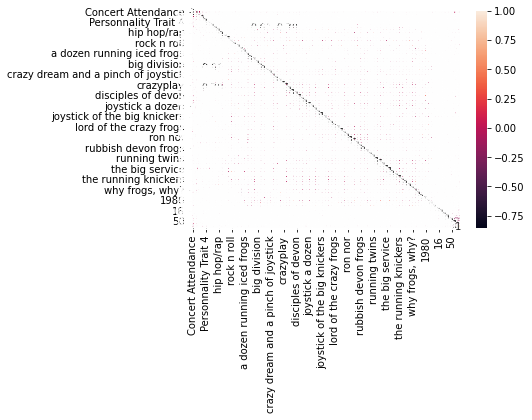

In [ ]:
corr_matrice = df.corr()
sns.heatmap(corr_matrice, annot=True)
plt.show()

## Modèles

### Split du DataSet

In [ ]:
"""
Séparer train et test après le 
train = df[df.PassengerId.isin(df_train.PassengerId)]
test = df[df.PassengerId.isin(df_test.PassengerId)]
"""
colsToDrop = ["Id","Concert Enjoyment","Concert ID","Concert Goer Country of Origin","Concert Goer ID"] #on peut ajouter toutes les colonnes inutiles qu'on veut
X = df.drop(colsToDrop, axis=1)   
y = df['Concert Enjoyment']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, stratify=df['Concert Enjoyment'], random_state=1)

### Modèle Random Forest

In [ ]:
%timeit


#"""  a decommenter si on ne veut pas de balancer
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_balanced , y_balanced =  over_sampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split( X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=1)
#"""


random_state =2
from sklearn.ensemble import RandomForestClassifier 
RF =  RandomForestClassifier(random_state=random_state)
RF.fit(X_train, y_train)

RandomForestClassifier(random_state=2)

### Evaluation du modèle baseline

In [ ]:
y_prob_train = RF.predict_proba(X_train)[:,1]
y_pred_train = RF.predict(X_train)
y_prob = RF.predict_proba(X_test)[:,1]
y_pred = RF.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer ,f1_score,precision_score,recall_score,r2_score

print('Accuracy for train: ',accuracy_score(y_train,y_pred_train))

Accuracy for train:  0.993394017944158


In [ ]:
print('Accuracy for test: ',accuracy_score(y_test,y_pred))

Accuracy for test:  0.8062733593216252


In [ ]:
print('Confusion matrix - Train: ','\n',confusion_matrix(y_train,y_pred_train))
print('Overall accuracy - Train: ',accuracy_score(y_train,y_pred_train))

Confusion matrix - Train:  
 [[49732     3    30     0]
 [   13 49176   286   290]
 [  383   274 49098    11]
 [    0    24     1 49741]]
Overall accuracy - Train:  0.993394017944158


In [ ]:
print('Confusion matrix - Test: ','\n',confusion_matrix(y_test,y_pred))
print('Overall accuracy - Test: ',accuracy_score(y_test,y_pred))

Confusion matrix - Test:  
 [[12132     8   302     0]
 [  100  8083  2740  1519]
 [ 1671  3019  7670    81]
 [    0   195     6 12240]]
Overall accuracy - Test:  0.8062733593216252


In [ ]:
print(classification_report(y_train,y_pred_train))

                    precision    recall  f1-score   support

 Best Concert Ever       0.99      1.00      1.00     49765
     Did Not Enjoy       0.99      0.99      0.99     49765
           Enjoyed       0.99      0.99      0.99     49766
Worst Concert Ever       0.99      1.00      1.00     49766

          accuracy                           0.99    199062
         macro avg       0.99      0.99      0.99    199062
      weighted avg       0.99      0.99      0.99    199062



In [ ]:
print(classification_report(y_test,y_pred))
print('Overall precision - Test: ',precision_score(y_test,y_pred, average='micro'))
print('Overall recall - Test: ',recall_score(y_test,y_pred, average='micro'))
print('Overall f1_score - Test: ',f1_score(y_test,y_pred, average='micro'))



                    precision    recall  f1-score   support

 Best Concert Ever       0.87      0.98      0.92     12442
     Did Not Enjoy       0.71      0.65      0.68     12442
           Enjoyed       0.72      0.62      0.66     12441
Worst Concert Ever       0.88      0.98      0.93     12441

          accuracy                           0.81     49766
         macro avg       0.80      0.81      0.80     49766
      weighted avg       0.80      0.81      0.80     49766

Overall precision - Test:  0.8062733593216252
Overall recall - Test:  0.8062733593216252
Overall f1_score - Test:  0.8062733593216254


### Save du modèle

In [ ]:
import pickle 
modelToSave = RF
with open('modeleSaved.pkl','wb') as f:
    pickle.dump(modelToSave,f)

# et pour load le modèle  
#with open('modeleSaved.pkl', 'rb') as f:
#    modeleSaved = pickle.load(f)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

print('AUC of train: ', roc_auc_score(y_train, y_prob_train)) #for train data

fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Train data')
plt.show()

ValueError: ignored

In [ ]:
print('AUC of test: ', roc_auc_score(y_test, y_prob)) #for test data

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel(c'FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Test data')
plt.show()

## Identification des features les plus importantes 

In [ ]:
model =      RF              # on met le model qu'on souhaite expliquer
importances = model.feature_importances_
indices = np.argsort(importances)
# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Importances des variables')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [colonnes[i] for i in indices])
plt.xlabel('Importance relative')#plt.savefig('importances_variables_du_modele.png', dpi=300, bbox_inches='tight')
plt.show()